**Прогнозирование температуры звезды**

Есть задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

- закон смещения Вина
- закон Стефана-Больцмана
- спектральный анализ

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Цель иследования**
- предсказать температуру звёзды.

**Ход исследования**

1. Загрузка исходных данных из файла: `/datasets/6_class.csv `.
2. Исследовательский анализ
3. Подготовка данных к построению модели
4. Построение простой модели нейронной сети — baseline
5. Улучшение сети
6. Выводы по проекту

**Что важно учесть при выполнении проекта**

Как известно данные не идельны. Во время загрузки, преоразования из одного формата в другой могут возникнуть технологические 
ошибки. Так же во время наполнения базы обсерватории сотрудники могли допустить различные опечатки, либо перепутать переменные в столбцах, ведь человеческий фактор присутствует в любой сфере. Поэтому для качественного выполнения проекта необходимо основательно сделать предобработку данных и обратить внимание на следующие моменты:

1. описать найденные в данных проблемы,
2. применить различные методы: замену типов данных, обработку пропусков случайных, неслучайных и полностью случайных, обработку явных и не явных дубликатов,
3. использовать категоризацию данных,
4. применить четкую  структуру проекта и придерживаться хорошего стиля при написании кода,
5. обозначить выводы по этапам,
6. кратко комментировать шаги,
7. использовать срезы данных,
8. построить графики для решения задич,
9. использовать различные методы построения графиков,
10. использовать сводные таблицы для вывода данных,
11. объяснить, как коррелируют между собой различные величины или показатели. 

# Исследовательский анализ данных

Исследовательский анализ данных (Exploratory Data Analysis, EDA) — является важным этапом, который позволяет лучше понять данные и выявить основные характеристики и закономерности. Все выявленные проблемы на данном этапе будут исправлены в шаге предобработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder,
    FunctionTransformer
)
import torch
import torch.nn as nn
import re
from math import ceil

import warnings
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Вывод всех столбцов и строк, независимо от их количества.
pd.set_option('display.max_columns', None)

# Отключаем предупреждение
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

## Загрузка данных

In [2]:
try: data = pd.read_csv('/...')    
except: data = pd.read_csv('...')

In [3]:
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


## Соответствие техническому описанию

Для этой задачи заказчик предоставил данные с признаками:

- Temperature — абсолютная температура T(K) на поверхности звезды в Кельвинах.
- Luminosity — относительная светимость L/Lo звезды относительно Солнца
- Radius — относительный радиус R/Ro звезды относительно радиуса Солнца
- Absolute magnitude — абсолютная физическая  велчина Mv, характеризующая блеск звезды.
- Star color — цвет звезды, который определяют на основе спектрального анализа.
- Star type — тип звезды.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.3+ KB


Данные соответствуют техническому описанию, пропуски отсутствуют

## Форматирование

Удалим не информативный столбец **Unnamed: 0**, который дублирует инфексы

In [5]:
data = data.drop(['Unnamed: 0'], axis=1)

Для удобство обработки данныйх форматируем названия столбцов

In [6]:
data = data.rename(columns={
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'absolute_magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color'
})

## Дубликаты

Проверим данные на полные дубликаты, явные и не явные

In [7]:
def count_duplicates(df):
    # Создаем список для хранения результатов
    duplicates_summary = []

    # Проверяем дубликаты по всем строкам
    total_duplicates = df.duplicated(keep=False).sum()
    duplicates_summary.append({'Column': 'Полные дубли (все столбцы)', 'Количество дубликатов': total_duplicates})

    # Проходим по каждому столбцу DataFrame
    for column in df.columns:
        # Проверяем дубликаты в текущем столбце
        duplicate_count = df[column].duplicated(keep=False).sum()
        
        # Добавляем результат в список
        duplicates_summary.append({'Column': column, 'Количество дубликатов': duplicate_count})

    # Преобразуем список в DataFrame
    duplicates_summary = pd.DataFrame(duplicates_summary)

    # Сортируем по количеству дубликатов
    duplicates_summary = (
        duplicates_summary
        .sort_values(by='Количество дубликатов', ascending=False)
        .set_index('Column')
        .T
    )

    display(duplicates_summary)

In [8]:
count_duplicates(data)

Column,star_type,star_color,luminosity,radius,temperature,absolute_magnitude,Полные дубли (все столбцы)
Количество дубликатов,240,233,58,44,23,23,0


Полные дубликаты отсутствуют, есть некоторое количество явных дублей в столбцах. Некоторое количество дублей, это повторяющиеся уникальные значения в столбцах. Например в столбце temperature 23 звезды имеют одинаковую температуру. Далее поиск не явных дубликатов.

In [9]:
data.star_type.unique()

array([0, 1, 2, 3, 4, 5])

In [10]:
data.star_color.unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [11]:
data.star_color.value_counts()

star_color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: count, dtype: int64

Присутствуют не явные дубликаты, исправим их с помощию функции и регулярных выражений. По Гравардской классификации принято 
различать сдеждующие цвета звезд:

- Голубой
- Бело-голубой
- Белый
- Жёлто-белый
- Жёлтый
- Оранжевый
- Красный

In [12]:
# Функция для преобразования регулярных выражений и неявных дублей
def clean_format_str(df, column_name, regex_pattern, replace_str):
    """
    Заменяет тире на пробелы, приводит строки к нижнему регистру и удаляет регулярные выражения.

    :param df: DataFrame, содержащий данные
    :param column_name: Название столбца, который нужно очистить
    :param regex_pattern: Регулярное выражение для удаления
    :param replace_str: Словарь для замены строк неявных дубликатов
    :return: DataFrame с очищенным и отформатированным столбцом
    """
    # Заменяем тире на пробелы, удаляем регулярные выражения и приводим к нижнему регистру
    df[column_name] = df[column_name].str.replace('-', ' ', regex=False) \
                                      .str.replace(regex_pattern, '', regex=True) \
                                      .str.lower() \
                                      .str.strip() \
                                      .replace(replace_str)
    
    return df

In [13]:
regex_pattern = r'\s*$.*?$'
replace_str = {
    'whitish': 'white',
    'yellowish': 'yellow',
    'yellowish white': 'yellow white',
    'white yellow': 'yellow white',
    'Star type': 'star_type',
    'Star color': 'star_color',
    'pale yellow orange': 'orange',
    'orange red': 'orange'
}
data = clean_format_str(data, 'star_color', regex_pattern, replace_str)

In [14]:
data.star_color.value_counts()

star_color
red             112
blue             56
blue white       41
white            12
yellow white     12
orange            4
yellow            3
Name: count, dtype: int64

## Новые признаки

Feature engineering — это важный этап в процессе анализа данных и машинного обучения, который включает создание новых признаков на основе существующих. 
Для более глубокого обучения нейросети создадим новые признаки:

- temperature_stef_boltz — закон Стефана-Больцмана описывает связь светимости черного тела с его температурой
- wavelength_max — закон смещения Вина описывает связь между температурой черного тела и длиной волны, на которой оно излучает максимальную интенсивность
- relative_brightness — относительная яркость
- log_luminosity — логарифм относительной светимости 
- log_radius — логарифм относительного радиуса 
- luminosity_radius_ratio — комбинированный признак, отношение светимости и радиуса
- luminosity_radius — комбинированный признак, произведение светимости и радиуса
- luminosity_squared — квадрат светимости могут помочь выявить нелинейные зависимости
- radius_square — сравнительный радиус, квадрат радиуса может быть полезен для моделирования зависимости светимости от радиуса (
- lum_magnitude — отношение абсолютной величины к светимости, может помочь в анализе блеска звезды.
- luminosity_percentage — светимость звезды в процентах относительно светимости Солнца в 15 степени.
- radius_percentage — радиус звезды в процентах относительно радиуса Солнца в 5 степени.

Эти новые признаки могут помочь улучшить качество модели и выявить скрытые зависимости в данных. Важно протестировать, какие из них действительно улучшают производительность модели, используя методы отбора признаков.

In [15]:
# Функция для создания новых признаков
def new_features(df):
    # Константы
    b = 2.898e-3  # м * К (постоянная смещения Вина)
    sigma = 5.67e-8  # Вт * м^-2 * К^-4 (постоянная Стефана-Больцмана)

    # Пример: создание новых признаков
    # 1. Оценка температуры (T) по закону Стефана-Больцмана
    # L = σ * (4 * π * R^2) * T^4
    # T = (L / (σ * (4 * π * R^2)))^(1/4)

    df['temperature_stef_boltz'] = ((df['luminosity'] * 3.828e26) / (sigma * (4 * np.pi * (df['radius'] * 6.957e8)**2)))**(1/4)

    # 2. Длина волны максимального излучения по закону смещения Вина
    df['wavelength_max'] = b / df['temperature_stef_boltz']

    # Признак: относительная яркость
    mean_absolute_magnitude = df['absolute_magnitude'].mean()
    df['relative_brightness'] = df['absolute_magnitude'] - mean_absolute_magnitude

    # Логарифм относительной светимости и радиуса
    df['log_luminosity'] = np.log1p(df['luminosity'])
    df['log_radius'] = np.log1p(df['radius'])

    # Отношение светимости к радиусу
    df['luminosity_radius_ratio'] = df['luminosity'] / df['radius']

    # Квадрат радиуса и светимости
    df['luminosity_squared'] = df['luminosity'] ** 2
    df['radius_squared'] = df['radius'] ** 2

    # Комбинированные признаки
    df['luminosity_radius'] = df['luminosity'] * df['radius']

    # Создание числовых признаков
    df['lum_rad'] = df['luminosity'] / df['radius']

    solar_luminosity = 3.828 * 10**26  # Светимость Солнца
    solar_radius = 6.9551 * 10**8  # Радиус Солнца
    df['luminosity_percentage'] = ((df['luminosity'] / solar_luminosity) * 100 ** 15).astype(float)
    df['radius_percentage'] = (df['radius'] / solar_radius) * 100 **5

    # Преобразование star_type в строки вида "тип 0", "тип 1", и т.д.
    df['star_type'] = df['star_type'].apply(lambda x: f'тип {x}')

    return df

In [16]:
data = new_features(data)

## Статистический анализ

In [17]:
(
    data
    .drop('star_type', axis=1)
    .select_dtypes(include='number')
    .describe()
    .style.format('{:,.5f}')
)

,temperature,luminosity,radius,absolute_magnitude,temperature_stef_boltz,wavelength_max,relative_brightness,log_luminosity,log_radius,luminosity_radius_ratio,luminosity_squared,radius_squared,luminosity_radius,lum_rad,luminosity_percentage,radius_percentage
count,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000
mean,"10,497.46250","107,188.36163",237.15778,4.38240,"9,430.82259",0.00000,-0.00000,5.14473,2.15515,"2,207.22520","43,551,125,683.67885","322,579.52154","74,074,701.25376","2,207.22520","280,011,394.02980","3,409.83999"
std,"9,552.42504","179,432.24494",517.15576,10.53251,"9,828.61304",0.00000,10.53251,5.86072,2.63860,"6,454.67033","114,506,991,508.49289","773,800.38393","196,163,360.24449","6,454.67033","468,736,272.04863","7,435.63376"
min,"1,939.00000",0.00008,0.00840,-11.92000,966.13897,0.00000,-16.30240,0.00008,0.00836,0.00039,0.00000,0.00007,0.00000,0.00039,0.20899,0.12077
25%,"3,344.25000",0.00086,0.10275,-6.23250,"2,856.74837",0.00000,-10.61490,0.00086,0.09781,0.01057,0.00000,0.01056,0.00006,0.01057,2.25901,1.47733
50%,"5,776.00000",0.07050,0.76250,8.31300,"4,870.07211",0.00000,3.93060,0.06803,0.56656,0.24640,0.00518,0.58246,0.04063,0.24640,184.16928,10.96318
75%,"15,055.50000","198,050.00000",42.75000,13.69750,"12,489.75502",0.00000,9.31510,12.19628,3.77806,341.34207,"39,223,810,000.00000","1,829.25000","10,300,220.00000",341.34207,"517,371,995.82027",614.65687
max,"40,000.00000","849,420.00000","1,948.50000",20.06000,"48,986.33708",0.00000,15.67760,13.65231,7.57533,"58,071.42857","721,514,336,400.00000","3,796,652.25000","1,263,465,855.00000","58,071.42857","2,218,965,517.24138","28,015.41315"


Все звезды разные, одни большие и тусклые, другие маленькие и яркие. Так как небесные тела оценены и изучены обсерваторией объективно, будем считать, что числовые данные находятся в реальных рамках.

## Визуализация

### Количественные признаки

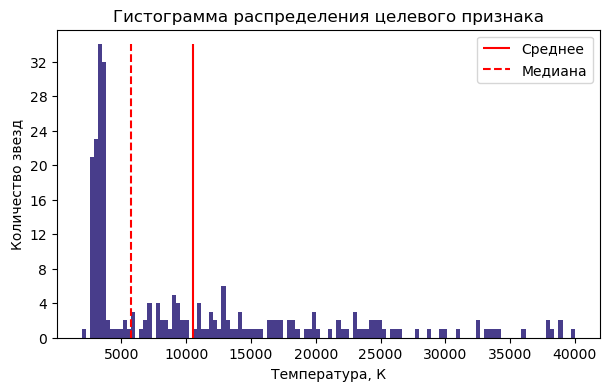

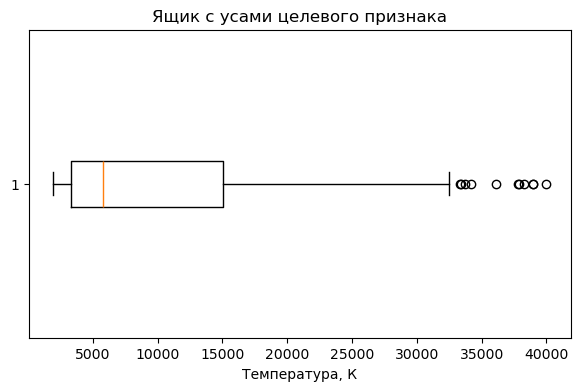

In [18]:
# Распределение целевого признака 
plt.rcParams["figure.figsize"] = (7, 4)
bins = plt.hist(
    data.temperature, 
    bins=120, 
    color='darkslateblue'
)
plt.vlines(
    x=data.temperature.mean(),
    colors='red', 
    ymin=bins[0].min(), 
    ymax=bins[0].max(), 
    label='Среднее'
)
plt.vlines(
    x=data.temperature.median(), 
    colors='red', 
    ymin=bins[0].min(), 
    ymax=bins[0].max(), 
    linestyles='--', 
    label='Медиана'
)
# Установка целых чисел по оси Y с использованием MaxNLocator
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Гистограмма распределения целевого признака')
plt.xlabel('Температура, К')
plt.ylabel('Количество звезд')
plt.legend()
plt.show()

# Ящик с усами целевого признака
plt.title('Ящик с усами целевого признака')
plt.boxplot(x=data.temperature, vert=False)
plt.xlabel('Температура, К')
plt.show()

In [19]:
def hist_box_num_sub(categ, data, bins, x, hue, title_hist, xlabel, ylabel, factor_vline, **kwargs):
    """
    categ - уникальные значения из любого категориального признака, по количеству которых будут определены цвета
    data - датафрейм
    bins - количество корзин
    x - ость, по которой распределяются значения количественного признака
    hue - семантическая переменная, которая сопоставляется для определения цвета элементов графика.
    title_hist - название гистограммы
    xlabel, ylabel - название осей
    factor_vline - множитель для средней и медианы
    **kwargs:
     - rotation=90 - угол поворота надписей по оси х
     - fig_size=(17, 4) - размер графиков
     - x_range=(0, 30) - ограничение диапазона по оси х
     - y_range=(0, 30) - ограничение диапазона по оси y
    Переменные categ и hue должны совпадать по количеству уникальных значений, так как палитра цветов строится на основе этого значения 
    """
    # Создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # Уникальные категории
    categories = categ

    # Случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}
    colors_box = {cat: random_color() for cat in categories}
	
	# Вертикальные линии
    mean = np.mean(data[x])
    median = np.median(data[x])
    
    # Инициализация объекта Figure и создание подграфиков
    fig_size = kwargs['fig_size'] if 'fig_size' in kwargs else (10, 10)
    fig, axes = plt.subplots(2, 1, figsize=fig_size)

    # Установка диапазона по оси x, если задан
    if 'x_range' in kwargs:
        axes[0].set_xlim(kwargs['x_range'])
        axes[1].set_xlim(kwargs['x_range'])
        
    # Установка диапазона по оси Y, если задан
    if 'y_range' in kwargs:
        axes[0].set_ylim(kwargs['y_range'])
        y_max = kwargs['y_range'][1] * factor_vline  # Используем верхнюю границу y_range
    else:
        y_max = axes[0].get_ylim()[1] * factor_vline  # Получаем текущее значение, если y_range не задан
    
    sns.histplot(data=data, 
                 x=x, 
                 bins=bins,
                 hue=hue,
                 palette=colors_hist,
                 ax=axes[0], 
                 kde=True,
                 multiple='stack',
                 legend=True
                )
    
    # Устанавливаем целые числа по оси Y
    axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    
    axes[0].vlines(mean, 0, y_max, color='red', label='Среднее')
    axes[0].vlines(median, 0, y_max, color='blue', linestyle='--', label='Медиана')
    axes[0].set_title(title_hist,  fontsize=9)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    
    sns.boxplot(data=data, 
                x=x, 
                hue=hue,
                palette=colors_box,
                ax=axes[1]
               )
    axes[1].set_title('Ящик с усами количественного признака',  fontsize=9)
    axes[1].set_xlabel(xlabel)
    axes[1].legend(title=hue, loc='upper left')
    plt.tight_layout()
    plt.show()

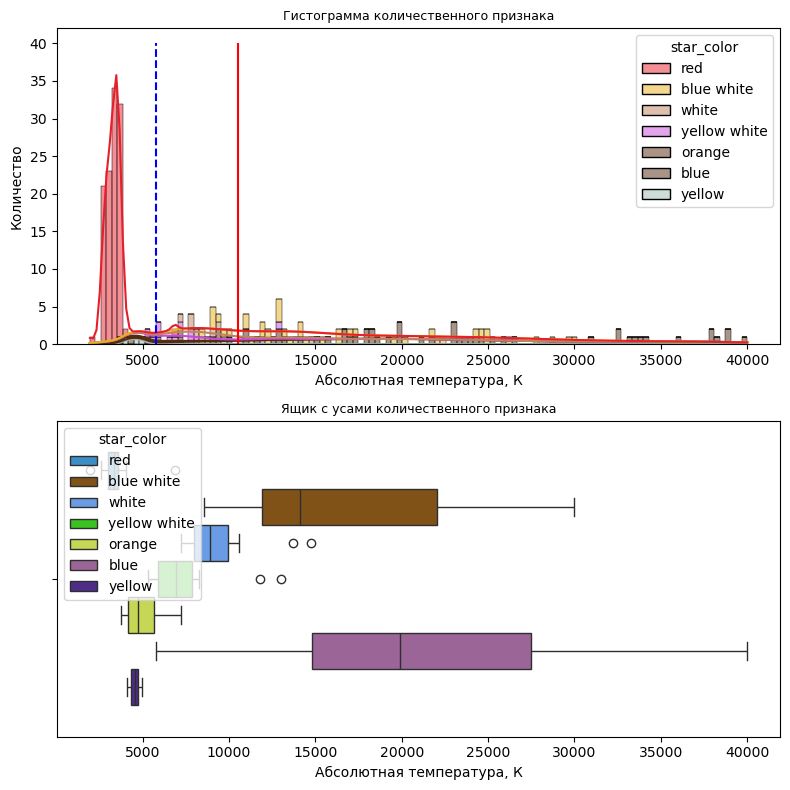

In [20]:
# temperature
hist_box_num_sub(
    data.star_color.unique(),
    data, 
    120,
    'temperature', 
    'star_color',
    'Гистограмма количественного признака', 
    'Абсолютная температура, К', 
    'Количество',
    40,
    fig_size=(8, 8)
)

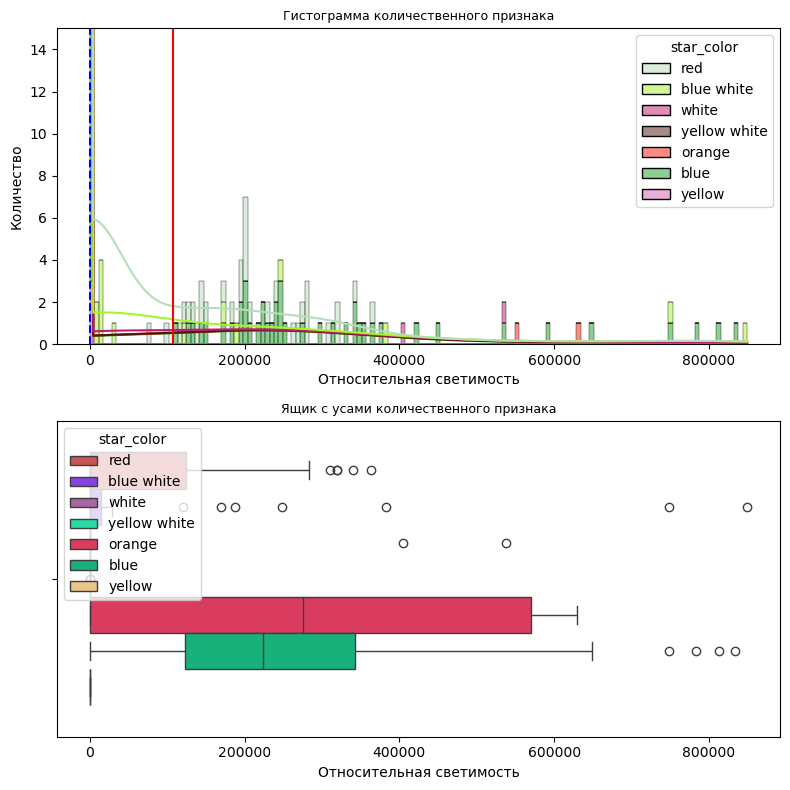

In [21]:
# luminosity
hist_box_num_sub(
    data.star_color.unique(),
    data,
    150,
    'luminosity', 
    'star_color',
    'Гистограмма количественного признака', 
    'Относительная светимость', 
    'Количество',
    40,
    fig_size=(8, 8),
    y_range=(0, 15)
)

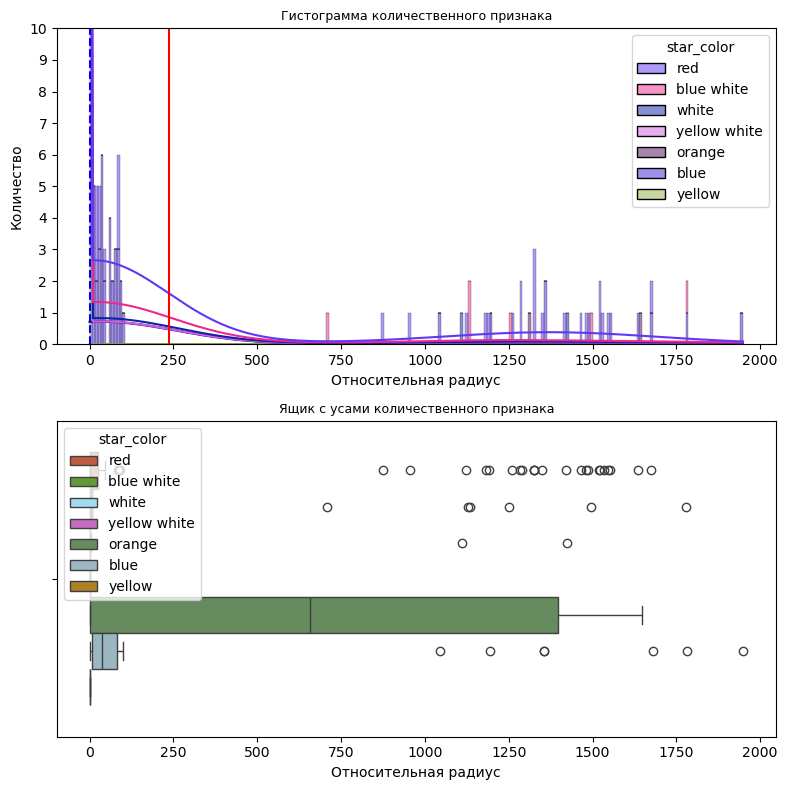

In [22]:
# radius
hist_box_num_sub(
    data.star_color.unique(),
    data,
    240,
    'radius', 
    'star_color',
    'Гистограмма количественного признака', 
    'Относительная радиус', 
    'Количество',
    30,
    fig_size=(8, 8),
    #x_range=(-10, 150),
    y_range=(0, 10)
)

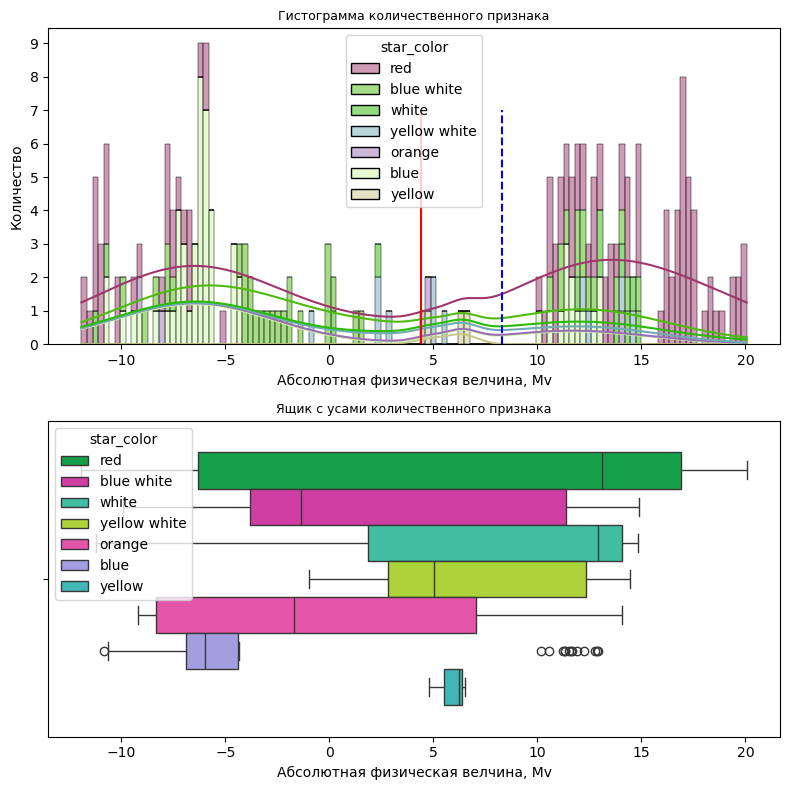

In [23]:
# absolute_magnitude
hist_box_num_sub(
    data.star_color.unique(),
    data,
    120,
    'absolute_magnitude', 
    'star_color',
    'Гистограмма количественного признака', 
    'Абсолютная физическая велчина, Mv', 
    'Количество',
    7,
    fig_size=(8, 8),
)

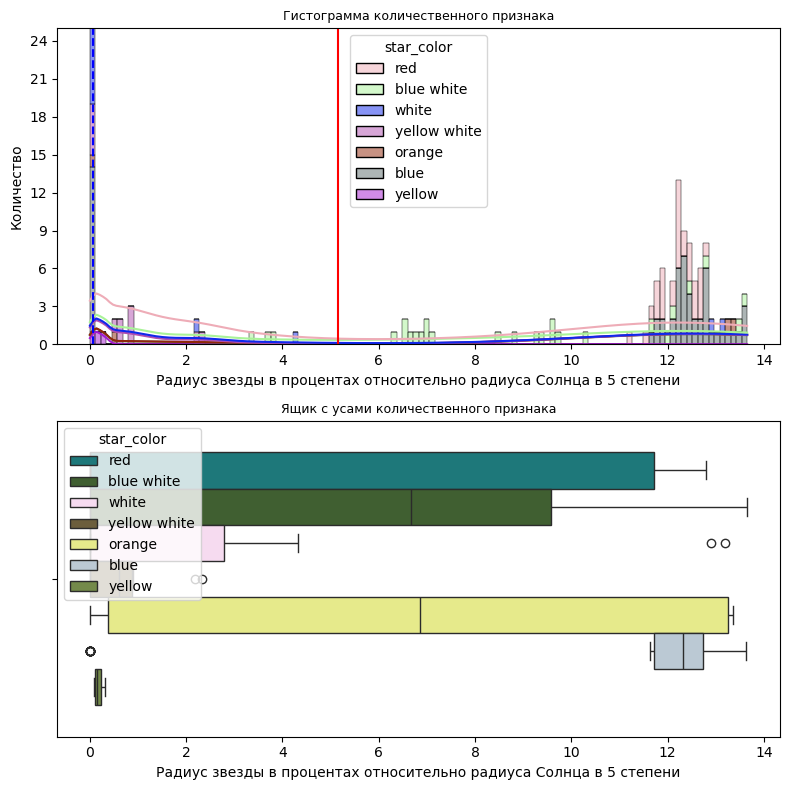

In [24]:
# log_luminosity
hist_box_num_sub(
    data.star_color.unique(),
    data,
    120,
    'log_luminosity', 
    'star_color',
    'Гистограмма количественного признака', 
    'Радиус звезды в процентах относительно радиуса Солнца в 5 степени', 
    'Количество',
    7,
    fig_size=(8, 8),
    y_range=(0, 25),
)

У всех признаков присутствуют выбросы, так же большая концентрация показателей в начале оси Х практически по всем признакам. 
Это говорит о там, что большое количество звезд сконцентрировано в узком диапазоне значени признаков.

### Категориальные признаки

In [25]:
def hist_countolot(categ, data, x, hue, xlabel, ylabel, title, **kwargs):
    """
    categ - уникальные значения из любого категориального признака, по количеству которых будут определены цвета
    data - датафрейм
    x - ость, по которой распределяются значения количественного признака
    hue - семантическая переменная, которая сопоставляется для определения цвета элементов графика.
    title - название гистограммы
    xlabel, ylabel - название осей
    **kwargs:
     - rotation=90 - угол поворота надписей по оси х
     - fig_size=(17, 4) - размер графиков
    ??? - x_range=(0, 30) - ограничение диапазона по оси х
    Переменные categ и hue должны совпадать по количеству уникальных значений, так как палитра цветов строится на основе этого значения 
    """
    
    # Создаем случайные цвета
    def random_color():
        return "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # Уникальные категории
    categories = categ

    # Случайные цвета для каждой категории
    colors_hist = {cat: random_color() for cat in categories}

    # Условие для переменного аргумента 
    if 'fig_size' in kwargs:
        plt.figure(figsize=kwargs['fig_size'])
    else: 
        plt.figure(figsize=(10, 4))
        
    # Гистограмма
    ax = sns.countplot(
        data,
        x=x, 
        palette=colors_hist,
        hue=hue, 
        stat='percent'
    )
    ax.set_title('График распределения категориального признака',  fontsize=9)
    
    # Настраиваем ось Y для отображения целых чисел
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title=title, loc='upper right')

    # Условие для переменного аргумента 
    if 'rotation' in kwargs:
        plt.xticks(rotation=kwargs['rotation'])

    plt.show()

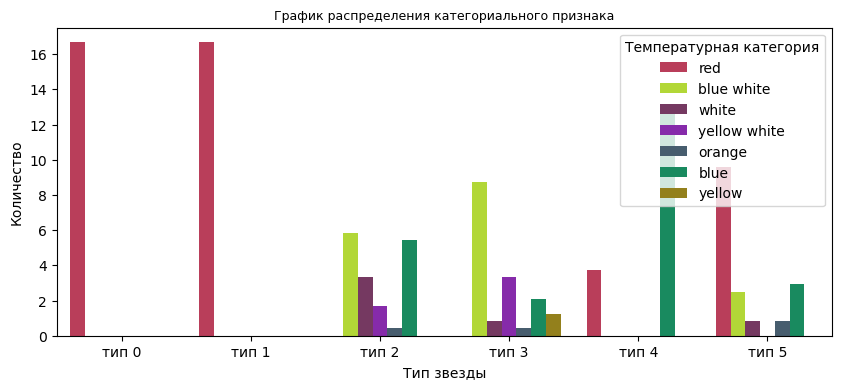

In [26]:
# star_type
hist_countolot(
    data.star_color.unique(),
    data, 
    'star_type', 
    'star_color', 
    'Тип звезды', 
    'Количество', 
    'Температурная категория',
) 

Преобладает цвет звезд red

### Корреляционный анализ

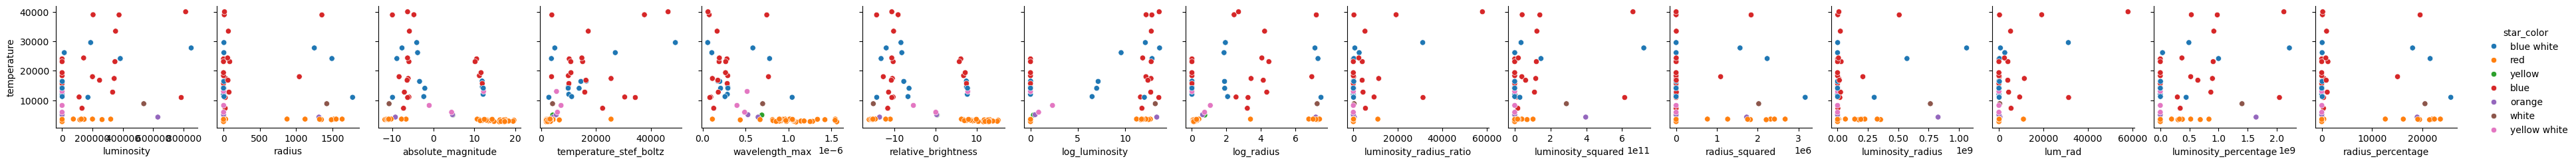

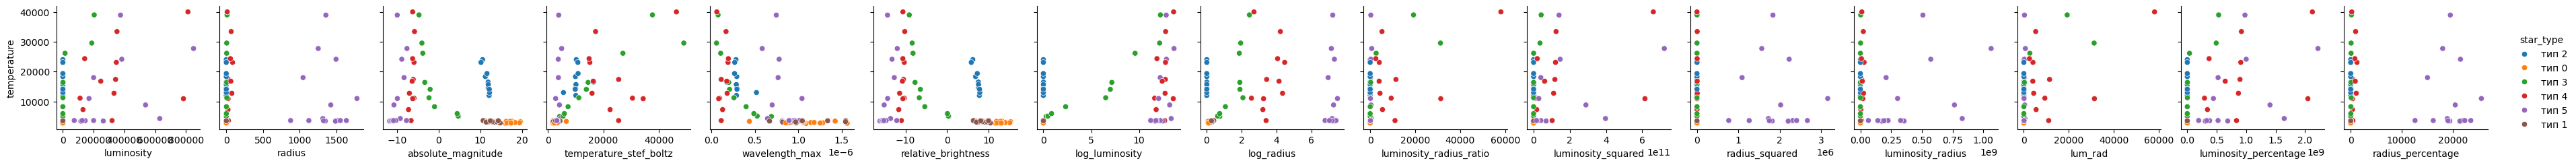

In [27]:
cat = ['star_color', 'star_type']
for category in cat:
    g = sns.PairGrid(
        data.sample(frac=0.3, random_state=42), 
        hue=category, 
        x_vars=(
            data
            .select_dtypes(include='number')
            .drop(['temperature'], axis=1)
            .columns
        ),
        y_vars='temperature'
    )
    g.map(sns.scatterplot)
    g.add_legend()
    plt.show()

На диаграммах нет четкой тенденции распрелеления данных - корреляция между целевым и количественными признаками отсутствует. 
Кроме **log_luminosity**, при повышении температуры значение признака возрастает, это говорит о положительной корреляции

In [28]:
# Считаем корреляцию
phik_overview = phik_matrix(
    data,
    interval_cols=(
        data
        .select_dtypes(include='number')
        .columns
    ) 
)

# Размер матрицы
phik_overview.shape

(18, 18)

In [29]:
# Функция для матрици корреляци
def plot_correlation_matrix(data, x_labels, y_labels, vmin, vmax, color_map, title, fontsize_factor, figsize):
    plt.figure(figsize=figsize)
    sns.heatmap(
        data, 
        annot=True, 
        fmt=".2f", 
        cmap=color_map, 
        vmin=vmin, 
        vmax=vmax, 
        cbar=False, 
        linewidths=0.5,
        linecolor='gray',
        xticklabels=x_labels, 
        yticklabels=y_labels
    )
    plt.title(title, fontsize=fontsize_factor * 10)
    plt.show()

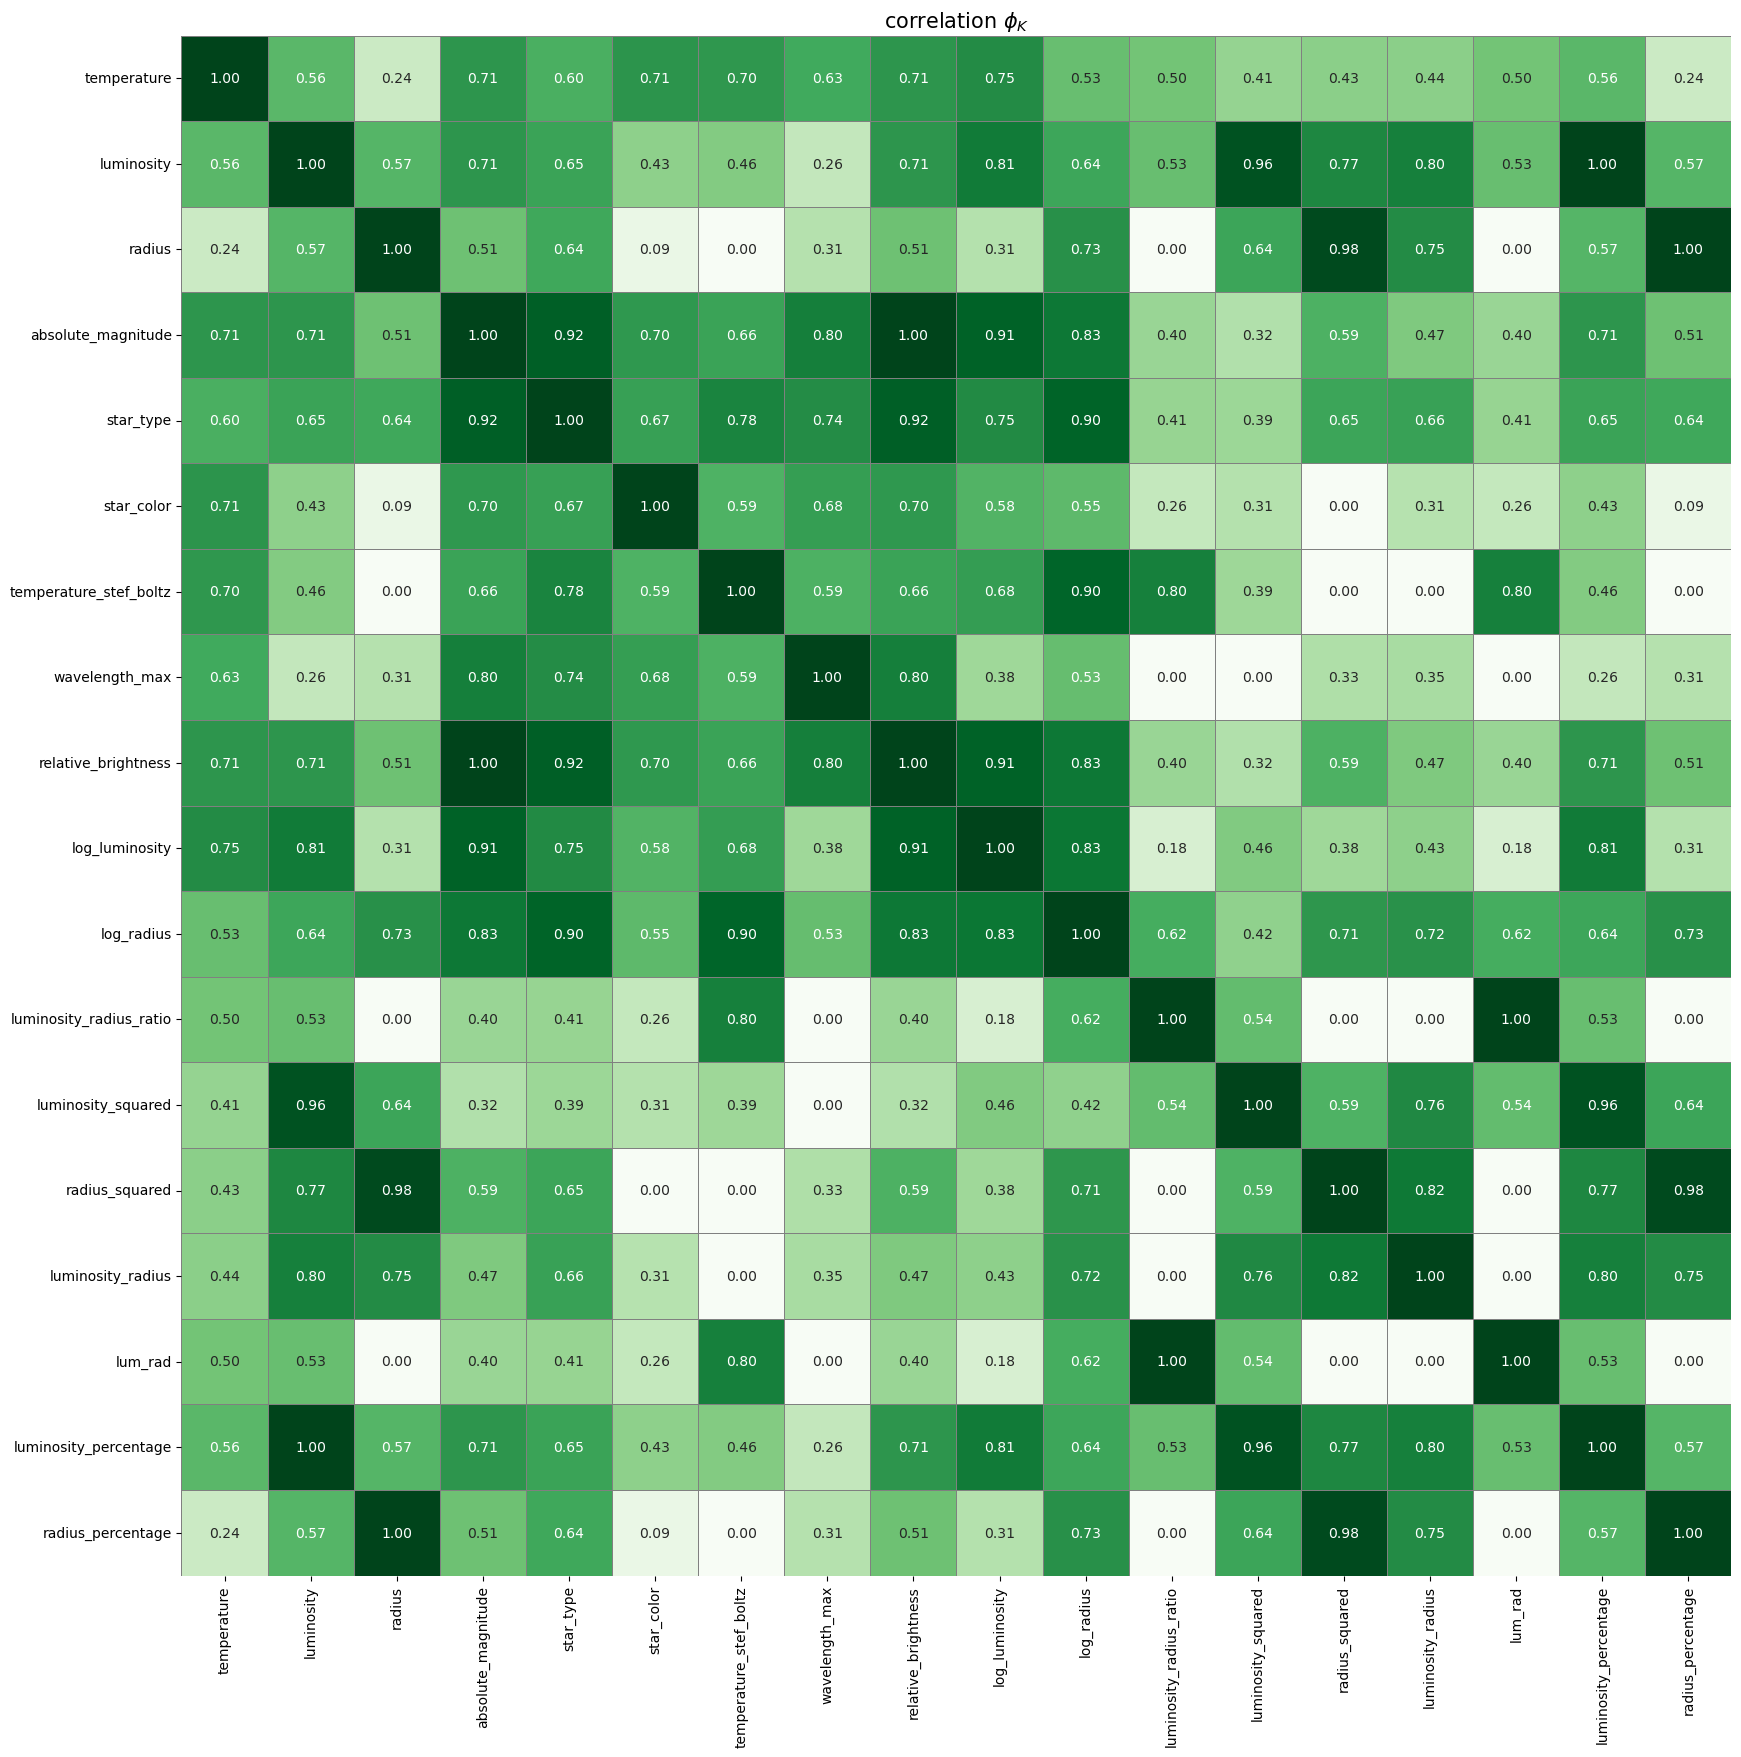

In [30]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 20)
)

После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:

- зеленые тона говорят о сильной линейной зависимости, а светлые — о слабой;
- корреляция между целевым и остальными достаточно очень слабая;
- мультикорреляция присутствует между парами **radius -> radius_percentage, radius -> radius_square, luminosity -> luminosity_percentage**
- утечки целевого признака через входящие не наблюдается.

По итогу список признаков для обучения сети:

- temperature,
- luminosity,
- radius,
- absolute_magnitude,
- star_type,
- star_color,
- temperature_stef_boltz
- wavelength_max,
- relative_brightness,
- log_luminosity,
- log_radius,
- luminosity_radius_ratio
- luminosity_squared
- radius_squared
- luminosity_radius
- lum_rad
- luminosity_percentage
- radius_percentage

# Предобработка данных

Подготовка данных для анализа называется предобработкой. Нужно оценить масштаб найденных проблем и устранить их. Предобработка следует принципу GIGO (от англ. garbage in — garbage out, буквально «мусор на входе — мусор на выходе»). Это значит, что при ошибках во входных данных даже правильный алгоритм работы приведёт к неверным результатам. Так же нужно помнить об законе экономии, который называется Бри́тва О́ккама. В нем говорится следующее: Не следует множить сущее без необходимости. Суть принципа: совершенство должно быть простым. Если какого-то результата можно достичь с привлечением сущностей A, B и C либо другим путём с привлечением A, B, С и D — надо выбирать первый путь. В плане программирования это значит, что не следут создавать промежуточные переменные, которые не пригодяться в дальнейшем.

Фильтруем выбросы и аномалии с помощью кастомного трансформера.

In [31]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold  # Порог для определения выбросов
        self.medians = {}  # Словарь для хранения медиан признаков
        self.thresholds = {}  # Словарь для хранения порогов

    def fit(self, X, y=None):
        # Исключаем признак из DataFrame

        # Сохраняем числовые признаки в список
        features = X.select_dtypes(include='number').columns.tolist()

        # Инициализируем словари для хранения медиан и порогов
        self.medians = {}
        self.thresholds = {}

        for feature in features:
            # Вычисляем первый и третий квартиль
            Q1 = X[feature].quantile(0.25)
            Q3 = X[feature].quantile(0.75)

            # Вычисляем IQR (межквартильный размах)
            IQR = Q3 - Q1

            # Определяем границы для выбросов
            lower_bound = Q1 - self.threshold * IQR
            upper_bound = Q3 + self.threshold * IQR

            # Проверяем, есть ли выбросы
            if (X[feature] < lower_bound).any() or (X[feature] > upper_bound).any():
                # Сохраняем медиану и порог для данного признака
                self.medians[feature] = X[feature].median()
                self.thresholds[feature] = self.threshold  # Используем заданный порог

        return self

    def transform(self, X):
        # Исключаем коррелирующие признаки из DataFrame

        # Преобразуем строковые значения в NaN в числовых столбцах
        for col in X.select_dtypes(include=['float64', 'int64']).columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # Создаем DataFrame для хранения информации о границах выбросов
        outlier_info = pd.DataFrame(columns=['Признак', 'Порог', 'Нижняя граница', 'Верхняя граница'])

        # Убираем выбросы из количественных признаков, определенных в fit
        for column in self.medians.keys():
            thresholds = self.thresholds[column]  # Используем заданный порог
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1

            # Определяем границы для выбросов
            lower_bound = Q1 - thresholds * IQR
            upper_bound = Q3 + thresholds * IQR

            # Добавляем информацию о выбросах в DataFrame
            outlier_info = pd.concat([
                outlier_info,
                pd.DataFrame([{
                    'Признак': column,
                    'Порог': thresholds,
                    'Нижняя граница': lower_bound,
                    'Верхняя граница': upper_bound
                }])
            ], ignore_index=True)

            # Заменяем выбросы на медиану
            median_value = self.medians[column]
            X[column] = np.where((X[column] < lower_bound) | (X[column] > upper_bound), median_value, X[column])

        # Заполняем NaN значения медианами
        for column in self.medians.keys():
            X[column].fillna(self.medians[column], inplace=True)

        display(outlier_info.set_index('Признак').T)

        return X

In [32]:
pipe_pre = Pipeline(
    [
        ('custom_transformer', CustomTransformer(threshold=0.1))
    ]
)
data_pre = pipe_pre.fit_transform(data)

Признак,temperature,luminosity,radius,absolute_magnitude,temperature_stef_boltz,wavelength_max,relative_brightness,log_luminosity,log_radius,luminosity_radius_ratio,luminosity_squared,radius_squared,luminosity_radius,lum_rad,luminosity_percentage,radius_percentage
Порог,0.100,0.100000,0.100000,0.1000,0.100000,1.000000e-01,0.100000,0.100000,0.100000,0.100000,1.000000e-01,0.100000,1.000000e-01,0.100000,1.000000e-01,0.100000
Нижняя граница,2173.125,-19804.999049,-4.161975,-8.2255,1893.447703,1.537891e-07,-12.607896,-1.218677,-0.270218,-34.122582,-3.922381e+09,-182.913386,-1.030022e+06,-34.122582,-5.173720e+07,-59.840621
Верхняя граница,16226.625,217854.999914,47.014725,15.6905,13453.055682,1.092682e-06,11.308104,13.415821,4.146086,375.475217,4.314619e+10,2012.173944,1.133024e+07,375.475217,5.691092e+08,675.974824


# Подготовка данных к построению модели

In [33]:
# Обучающая и тестовая выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Нормализация числовых и преобразование категориальных признаков
def preprocess_data(df):
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(['temperature'], axis=1),
        df['temperature'],
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=df['star_color']
    )

    # Определяем количественные и категориальные признаки
    numeric_features = ['luminosity', 'radius', 'absolute_magnitude',
       'temperature_stef_boltz', 'wavelength_max',
       'relative_brightness', 'log_luminosity', 'log_radius',
       'luminosity_radius_ratio', 'luminosity_squared', 'radius_squared',
       'luminosity_radius', 'lum_rad',
       'luminosity_percentage', 'radius_percentage']
    categorical_features = ['star_color', 'star_type']

    # Создаем трансформеры для количественных и категориальных признаков
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')  # drop='first' для избежания дамми-ловушки

    # Создаем колонный трансформер
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Применяем трансформер к обучающим данным
    X_train_transformed = preprocessor.fit_transform(X_train)

    # Применяем трансформер к тестовым данным
    X_test_transformed = preprocessor.transform(X_test)

    # Получаем имена новых признаков после OneHotEncoding
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + ohe_feature_names.tolist()

    # Создаем новый DataFrame с преобразованными данными
    X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
    X_test_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

    # Масштабируем целевую переменную
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    # Преобразуем данные в тензоры
    X_train_tensor = torch.FloatTensor(X_train_df.values)
    X_test_tensor = torch.FloatTensor(X_test_df.values)
    y_train_tensor = torch.FloatTensor(y_train_scaled).view(-1, 1)  # Преобразуем в 2D тензор
    y_test_tensor = torch.FloatTensor(y_test_scaled).view(-1, 1)    # Преобразуем в 2D тензор

    print("X shape:", df.drop(['temperature'], axis=1).shape)
    print("y shape:", df['temperature'].shape)
    
    return X_train, X_test, y_train_scaled, y_test_scaled, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_scaler, y_test_scaled

In [34]:
(
    X_train, X_test, 
    y_train_scaled, y_test_scaled, 
    X_train_tensor, X_test_tensor, 
    y_train_tensor, y_test_tensor,
    y_scaler, y_test_scaled
) = preprocess_data(data_pre)

# Проверка результата
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X shape: (240, 17)
y shape: (240,)
X_train_tensor shape: torch.Size([180, 26])
X_test_tensor shape: torch.Size([60, 26])
y_train_tensor shape: torch.Size([180, 1])
y_test_tensor shape: torch.Size([60, 1])


# Обучение модели

Для решения задачи линейной регрессии обучим нейросеть с следующими параметрами.

Комбинация один
- количество входных нейронов 26, так как после пдготовки данных есть 18 признаков
- базовая сеть - два скрытых слоя, на первом 1300 нейронов, на втором 650
- функция активации на первом скрытом гиперболический тангенс, на втором линейный выпрямитель
- на выходе 1 нейрон
- скорость обучения 0.0005

Комбинация два
- количество входных нейронов 26, так как после пдготовки данных есть 18 признаков
- два скрытых слоя, на первом 260 нейронов, на втором 130
- функция активации на первом скрытом сигмоидальная, на втором гиперболический тангенс
- на выходе 1 нейрон и нелинейность в выходных данных
- скорость обучения 0.001

In [35]:
# Определяем нейронную сеть
class StarTemperatureModel(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(StarTemperatureModel, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Tanh()
	
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)		
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

# Функция для обучения модели и построения графика
def train_and_plot(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, learning_rate):
    # Создание модели
    model = StarTemperatureModel(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

    # Определение функции потерь и оптимизатора
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Один шаг обучения
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Прогнозирование
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor).squeeze().numpy()  # Предсказания на тестовых данных

        # Обратное преобразование предсказанных значений
        y_test_pred_kelvins = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()
        y_test_actual_kelvins = y_scaler.inverse_transform(y_test_tensor.numpy()).squeeze()

    
    # Вычисление RMSE
    rmse = np.sqrt(np.mean((y_test_actual_kelvins - y_test_pred_kelvins) ** 2))
    
    # Построение графика
    plt.figure(figsize=(17, 8))
    indices = range(len(y_test_actual_kelvins))  # Индексы для графика
    plt.bar(indices, y_test_actual_kelvins, color='blue', alpha=0.5, label='Фактическая температура')
    plt.bar(indices, y_test_pred_kelvins, color='orange', alpha=0.5, label='Предсказанная температура')
    plt.xlabel('Индексы звёзд')
    plt.ylabel('Температура, К')
    plt.title('Факт — Прогноз температуры звёзд (тестовые данные)')
    plt.legend()
    plt.show()
    
    return round(rmse)

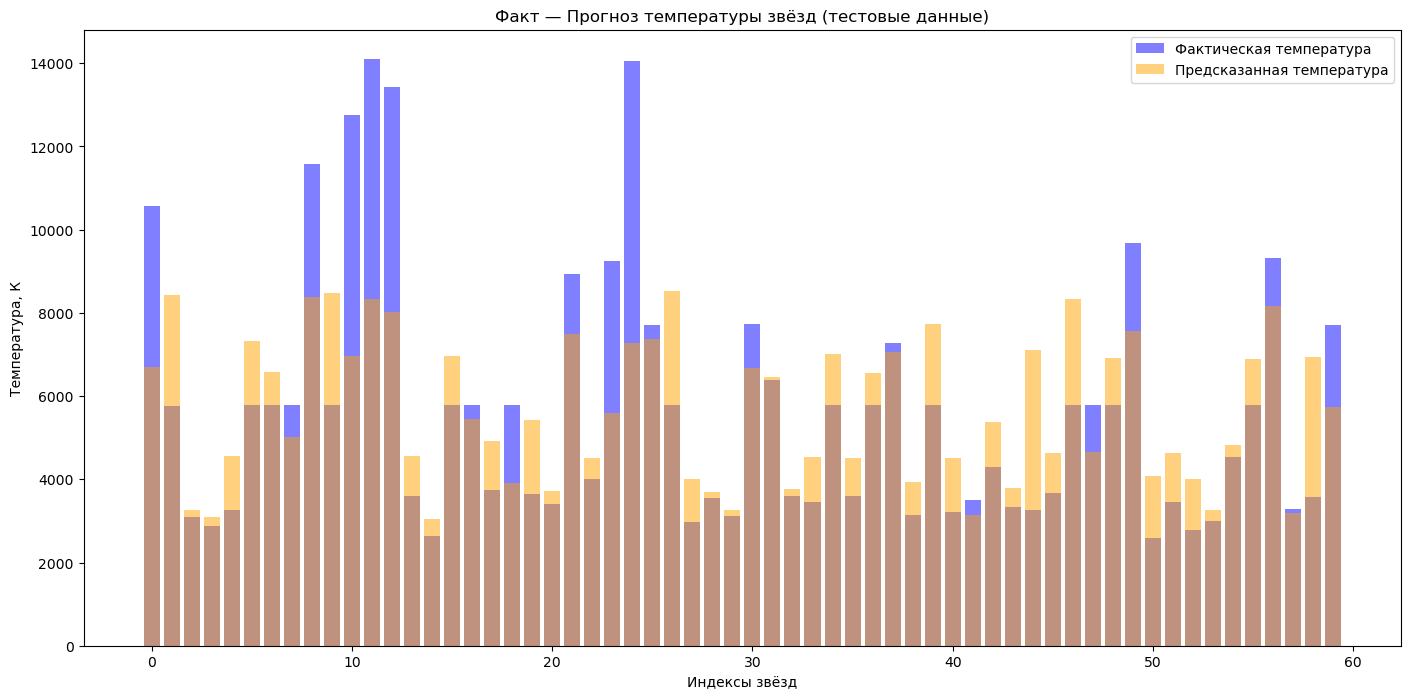

In [36]:
# Комбинация один
var_one = train_and_plot(
    26, 
    1300, 
    650, 
    1, 
    0.0005
)

In [37]:
# Определяем нейронную сеть
class StarTemperatureModel(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(StarTemperatureModel, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Sigmoid()
	
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)		
        self.act2 = nn.Tanh()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

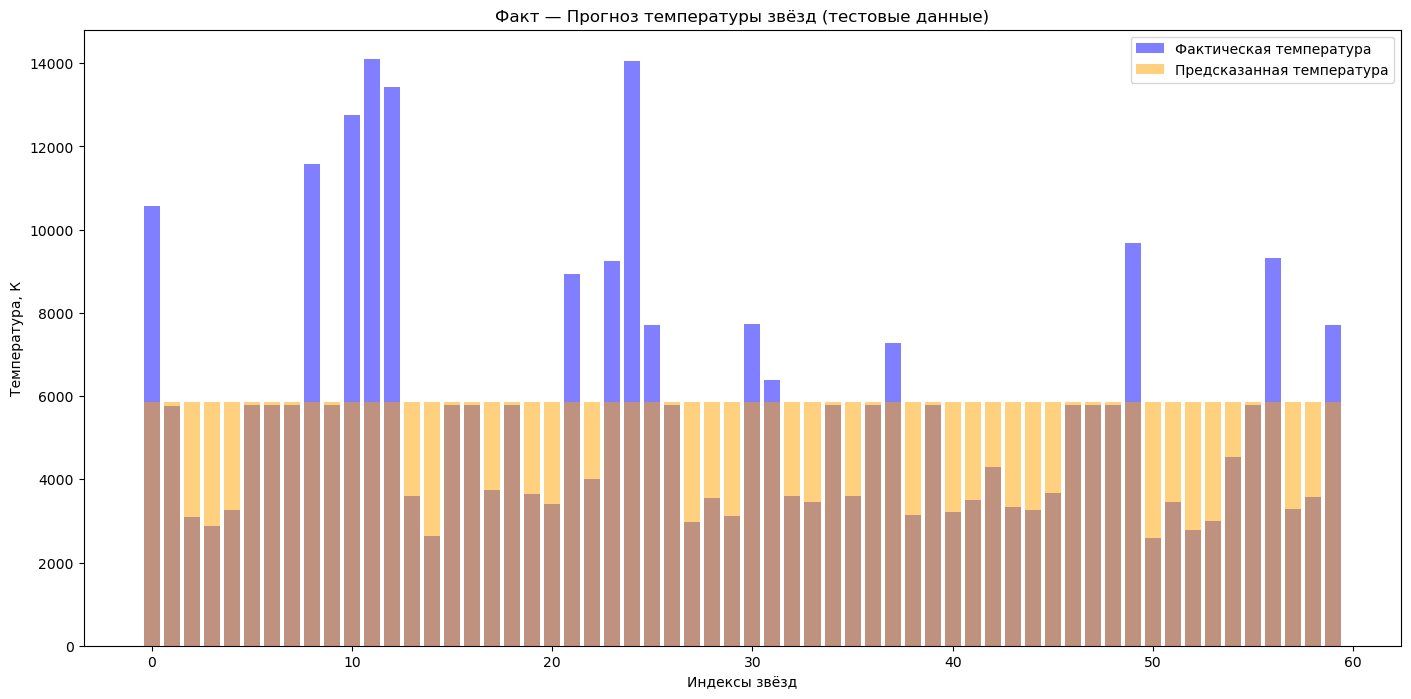

In [38]:
# Комбинация два
var_two = train_and_plot(
    26, 
    260, 
    130, 
    1, 
    0.001
)

In [39]:
# Создаем пустой DataFrame для хранения результатов
results = pd.DataFrame(columns=[
    'Итерация', 'Входные нейроны', 'Скрытые нейроны 1', 
    'Скрытые нейроны 2', 'Выходные нейроны', 'Скорость обучения', 'RMSE на тесте'
])

# Итерация 1
results = pd.concat([results, pd.DataFrame([{
    'Итерация': 1,
    'Входные нейроны': 26,
    'Скрытые нейроны 1': 1300,
    'Скрытые нейроны 2': 650,
    'Выходные нейроны': 1,
    'Скорость обучения': 0.0005,
    'Функция активации скрытого слоя 1': 'Tanh',
    'Функция активации скрытого слоя 2': 'ReLU',
    'RMSE на тесте': var_one
}])], ignore_index=True)

# Итерация 2
results = pd.concat([results, pd.DataFrame([{
    'Итерация': 2,
    'Входные нейроны': 26,
    'Скрытые нейроны 1': 260,
    'Скрытые нейроны 2': 130,
    'Выходные нейроны': 1,
    'Скорость обучения': 0.001,
    'Функция активации скрытого слоя 1': 'Sigmoid',
    'Функция активации скрытого слоя 2': 'Tanh',
    'RMSE на тесте': var_two
}])], ignore_index=True)

# Отображаем результаты с переводом
display(results.set_index('Итерация').T)

Итерация,1,2
Входные нейроны,26,26
Скрытые нейроны 1,1300,260
Скрытые нейроны 2,650,130
Выходные нейроны,1,1
Скорость обучения,0.0005,0.001
RMSE на тесте,2189,2992
Функция активации скрытого слоя 1,Tanh,Sigmoid
Функция активации скрытого слоя 2,ReLU,Tanh


По итогу обучения следующие параметры влияют на результат: 

- количество нейронов на скрытых слоях влияяет на результат, очень малое количество и очень большое количество ухудшает результат
- скорость обучения также влияет на качество предсказания

Необходимо улучшить сеть, так как значение ошибки не укладывется в необходимый минимум 4500 K/

## Улучшение сети

В этом разделе улучшим показтели обучения с помощью батчей, дропаута и регуляризации. За основу возьмем архитектуру базовой сети.

- количество входных нейронов 26, так как после пдготовки данных есть 18 признаков
- два скрытых слоя, на первом 1300 нейронов, на втором 650
- функция активации на первом скрытом нелинейность в выходных данных, на втором нелинейность в выходных данных
- на выходе 1 нейрон
- скорость обучения 0.0001
- размер батчей от 16 до 64
- регуляризация от 0.0 до 0.5
- количество эпох 100

In [40]:
# Определяем нейронную сеть с dropout
class StarTemperatureModel(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate):
        super(StarTemperatureModel, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Функция для обучения модели и получения метрик
def train_and_evaluate(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 
                       learning_rate, batch_size, dropout_rate, num_epochs):

    # Создание модели
    model = StarTemperatureModel(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate)

    # Определение функции потерь и оптимизатора
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Список для хранения метрик
    metrics = []

    # Обучение модели
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i + batch_size]
            y_batch = y_train_tensor[i:i + batch_size]

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Вычисление RMSE каждые 10 эпох
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_train_pred = model(X_train_tensor).squeeze().numpy()
                y_train_pred_kelvins = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).squeeze()
                y_train_actual_kelvins = y_scaler.inverse_transform(y_train_tensor.numpy()).squeeze()
                rmse = round(np.sqrt(np.mean((y_train_actual_kelvins - y_train_pred_kelvins) ** 2)))
                metrics.append((epoch, rmse))
                
    # Предсказания на тестовых данных
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor).squeeze().numpy()
        y_test_pred_kelvins = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()
        y_test_actual_kelvins = y_scaler.inverse_transform(y_test_tensor.numpy()).squeeze()

    return metrics, y_train_pred_kelvins, y_train_actual_kelvins, y_test_pred_kelvins, y_test_actual_kelvins

In [41]:
# Перебор параметров
dropout_rates = [0.0, 0.2, 0.5]
batch_sizes = [16, 32, 64]
results = []

# Запуск перебора параметров
for dropout_rate in dropout_rates:
    for batch_size in batch_sizes:
        metrics, y_train_pred_kelvins, y_train_actual_kelvins, y_test_pred_kelvins, y_test_actual_kelvins = train_and_evaluate(
            n_in_neurons=26,
            n_hidden_neurons_1=1300,
            n_hidden_neurons_2=650,
            n_out_neurons=1,
            learning_rate=1e-3,
            batch_size=batch_size,
            dropout_rate=dropout_rate,
            num_epochs=100
        )
        
        # Сохранение результатов
        final_rmse_train = metrics[-1][1]  # Последний RMSE на обучающей выборке
        final_rmse_test = round(np.sqrt(np.mean((y_test_actual_kelvins - y_test_pred_kelvins) ** 2)))  # RMSE на тестовой выборке
        results.append((dropout_rate, batch_size, final_rmse_train, final_rmse_test))

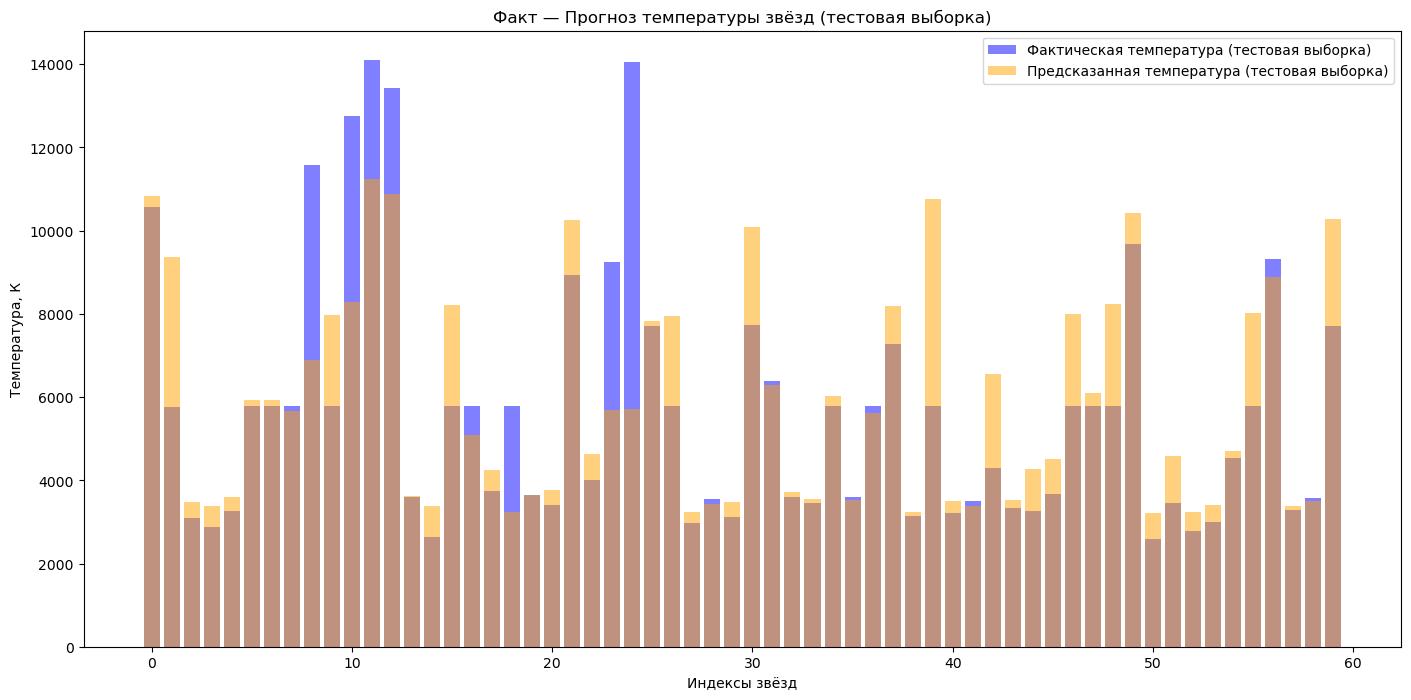

,Размер батча,RMSE (обучающая),RMSE (тестовая)
Регуляризация Dropout,,,
0.2,32,1335,1862
0.2,64,1343,1883
0.5,32,1496,1911
0.2,16,1315,1991
0.0,64,1177,1999
0.5,64,1522,2007
0.5,16,1523,2107
0.0,16,1366,2167
0.0,32,1335,2175


In [42]:
# Создание DataFrame для результатов
columns=[
    'Регуляризация Dropout', 
    'Размер батча', 
    'RMSE (обучающая)', 
    'RMSE (тестовая)', 
    ]

results_df = (pd.DataFrame(results, columns=columns)
              .set_index('Регуляризация Dropout')
              .sort_values('RMSE (тестовая)')
              )

# Построение графика фактических и предсказанных значений для тестовой выборки
plt.figure(figsize=(17, 8))
indices_test = range(len(y_test_actual_kelvins))  # Индексы для графика
plt.bar(indices_test, y_test_actual_kelvins, color='blue', alpha=0.5, label='Фактическая температура (тестовая выборка)')
plt.bar(indices_test, y_test_pred_kelvins, color='orange', alpha=0.5, label='Предсказанная температура (тестовая выборка)')
plt.xlabel('Индексы звёзд')
plt.ylabel('Температура, К')
plt.title('Факт — Прогноз температуры звёзд (тестовая выборка)')
plt.legend()
plt.show()

display(results_df)

**Описание столбчатой диаграммы.** С данными настройками значения температуры до 6 000 К сеть предсказывает достаточно точно, 
но пиковые значения в районе 6 000 - 14 000 К сеть предсказывает с ошибкой порядка 1862 К у разных звезд. Если сравнивать этот результат с базовой сетью, определенно есть улучшения в точности предсказания, метрика снизилась и на выходе более точные предсказания в.

# Выводы по проекту

Выполнив проект, сделаем следующие выводы:

1. Представленные данные соответствуют техническому описанию, пропуски отсутствуют
2. Удалили не информативный столбец **Unnamed: 0**, который дублирует инфексы
3. Полные дубликаты отсутствуют, есть некоторое количество явных дублей в столбцах. Далее поиск не явных дубликатов.
4. Присутствуют не явные дубликаты, исправили их с помощию функции и регулярных выражений
5. Создали новые синтетические признаки:

- temperature_stef_boltz — закон Стефана-Больцмана описывает связь светимости черного тела с его температурой
- wavelength_max — закон смещения Вина описывает связь между температурой черного тела и длиной волны, на которой оно излучает максимальную интенсивность
- relative_brightness — относительная яркость
- log_luminosity — логарифм относительной светимости 
- log_radius — логарифм относительного радиуса 
- luminosity_radius_ratio — комбинированный признак, отношение светимости и радиуса
- luminosity_radius — комбинированный признак, произведение светимости и радиуса
- luminosity_squared — квадрат светимости могут помочь выявить нелинейные зависимости
- radius_square — сравнительный радиус, квадрат радиуса может быть полезен для моделирования зависимости светимости от радиуса (
- lum_magnitude — отношение абсолютной величины к светимости, может помочь в анализе блеска звезды.
- luminosity_percentage — светимость звезды в процентах относительно светимости Солнца в 15 степени.
- radius_percentage — радиус звезды в процентах относительно радиуса Солнца в 5 степени.

6. В данных определенно присутствуют выбросы и аномалии, так как некоторые значения превышают в 3 раза стандартное отклонение. Провели дополнительный графический анализ данных, который подтвердил, что у всех признаков присутствуют выбросы, так же большая концентрация показателей в начале оси Х практически по всем признакам. Это говорит о там, что большое количество звезд сконцентрировано в узком диапазоне значени признаков.
7. Выяснили, что преобладает цвет звезд red и blue, относительно температуры - теплые и горячие.
8. На диаграммах нет четкой тенденции распрелеления данных - корреляция между целевым и количественными признаками отсутствует. Кроме **log_luminosity**, при повышении температуры значение признака возрастает, это говорит о положительной корреляции
9. После построение корреляционной матрицы входящих признаков к целевому можно сделать следующие выводы:
- зеленые тона говорят о сильной линейной зависимости, а светлые — о слабой;
- корреляция между целевым и остальными достаточно очень слабая;
- мультикорреляция присутствует между парами **radius -> radius_percentage, radius -> radius_square, luminosity -> luminosity_percentage**
- утечки целевого признака через входящие не наблюдается.

В итоге список признаков для обучения сети:
- temperature,
- luminosity,
- radius,
- absolute_magnitude,
- star_type,
- star_color,
- temperature_stef_boltz
- wavelength_max,
- relative_brightness,
- log_luminosity,
- log_radius,
- luminosity_radius_ratio
- luminosity_squared
- radius_squared
- luminosity_radius
- lum_rad
- luminosity_percentage
- radius_percentage

10. Для решения задачи линейной регрессии обучим нейросеть с следующими параметрами.

Комбинация один
- количество входных нейронов 26, так как после пдготовки данных есть 18 признаков
- базовая сеть - два скрытых слоя, на первом 1300 нейронов, на втором 650
- функция активации на первом скрытом гиперболический тангенс, на втором линейный выпрямитель
- на выходе 1 нейрон
- скорость обучения 0.0005

Комбинация два
- количество входных нейронов 26, так как после пдготовки данных есть 18 признаков
- два скрытых слоя, на первом 260 нейронов, на втором 130
- функция активации на первом скрытом сигмоидальная, на втором гиперболический тангенс
- на выходе 1 нейрон и нелинейность в выходных данных
- скорость обучения 0.001

По итогу обучения с разными параметрами сделали вывод: с исходным набором данных малое количество нейронов в скрытых слоях и разные варианты функций акитивации существенно влияют на результат предсказания.

11. В этом разделе улучшили показтели обучения с помощью батчей, дропаута и регуляризации. За основу взяли архитектуру базовой сети.

- количество входных нейронов 26, так как после пдготовки данных есть 18 признаков
- два скрытых слоя, на первом 1300 нейронов, на втором 650
- функция активации на первом скрытом нелинейность в выходных данных, на втором нелинейность в выходных данных
- на выходе 1 нейрон
- скорость обучения 0.0001
- размер батчей от 16 до 64
- регуляризация от 0.0 до 0.5
- количество эпох 100

И получили следующие результаты на выходе:

In [43]:
display(results_df.head())

,Размер батча,RMSE (обучающая),RMSE (тестовая)
Регуляризация Dropout,,,
0.2,32,1335,1862
0.2,64,1343,1883
0.5,32,1496,1911
0.2,16,1315,1991
0.0,64,1177,1999
